In [36]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

1632


In [26]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [27]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m        0.000000e+00   
                                                 pre_treatment_change_in_group_0_crimes_500m       9.289109e-52   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                6.801069e-02   
                                                 job_density_2013                                  2.155956e-56   
                                                 med_hhinc2016                                     4.926790e-01   
                                                 poor_share2010                                    2.727902e-21   
                                                 popdensity2010                                    1.237139e-37   
Panel C: Case Initiation                         for_cause                                         2.107174e-01   
                                                 no_cause                                          6.110806e-03   
                                                 non_payment                                       1.304311e-11   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          2.305030e-02   
                                                 hasAttyP                                          2.541567e-01   
                                                 isEntityD                                         1.658342e-06   
                                                 isEntityP                                         1.993951e-03   

                                                                                                            
                                                                                                            
                                                 \emph{Independent Variable}                                
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m   4.675480e-01  
                                                 pre_treatment_change_in_group_0_crimes_500m  4.594338e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           6.300067e-01  
                                                 job_density_2013                             6.967381e-01  
                                                 med_hhinc2016                                2.713150e-02  
                                                 poor_share2010                               3.442531e-03  
                                                 popdensity2010                               8.582592e-01  
Panel C: Case Initiation                         for_cause                                    4.074914e-03  
                                                 no_cause                                     2.626528e-02  
                                                 non_payment                                  4.274988e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     1.222082e-08  
                                                 hasAttyP                                     4.121382e-04  
                                                 isEntityD                                    1.523583e-01  
                                                 isEntityP                                    4.277201e-06

In [28]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1151.910995   
        Change in Crime Incidents, 2017-2019            -155.352880   
Panel B Job density, 2013                              16161.032515   
        Poverty rate, 2010                                 0.279638   
        Population density, 2010                       23320.185868   
Panel C Filing without cause                               0.033508   
        Filing for nonpayment                              0.716230   
Panel D Defendant has attorney                             0.011518   
        Defendant is entity                                0.019895   
        Plaintiff is entity                                0.808377   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                    -26.090482   
        Change in Crime Incidents, 2017-2019                            -8.082569   
Panel B Job density, 2013                                             -845.940269   
        Poverty rate, 2010                                              -0.022478   
        Population density, 2010                                      -128.009157   
Panel C Filing without cause                                            -0.022622   
        Filing for nonpayment                                           -0.107994   
Panel D Defendant has attorney                                          -0.050520   
        Defendant is entity                                             -0.011124   
        Plaintiff is entity                                             -0.083794   

                                                                         \
                                                  \emph{p}     Weighted   
Panel A Total Crime Incidents, 2017           4.675480e-01  -120.657437   
        Change in Crime Incidents, 2017-2019  4.594338e-01    13.349879   
Panel B Job density, 2013                     6.967381e-01 -1813.691835   
        Poverty rate, 2010                    3.442531e-03    -0.033358   
        Population density, 2010              8.582592e-01 -2341.867038   
Panel C Filing without cause                  2.626528e-02    -0.009018   
        Filing for nonpayment                 4.274988e-07    -0.098141   
Panel D Defendant has attorney                1.222082e-08    -0.013868   
        Defendant is entity                   1.523583e-01    -0.004773   
        Plaintiff is entity                   4.277201e-06    -0.101171   

                                                            
                                                  \emph{p}  
Panel A Total Crime Incidents, 2017           1.972697e-04  
        Change in Crime Incidents, 2017-2019  1.990008e-01  
Panel B Job density, 2013                     4.069974e-01  
        Poverty rate, 2010                    9.777436e-06  
        Population density, 2010              1.392377e-04  
Panel C Filing without cause                  3.674065e-01  
        Filing for nonpayment                 5.004038e-06  
Panel D Defendant has attorney                2.615948e-02  
        Defendant is entity                   5.392705e-01  
        Plaintiff is entity                   2.693417e-08

In [29]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [30]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:08<00:00, 127.35it/s]


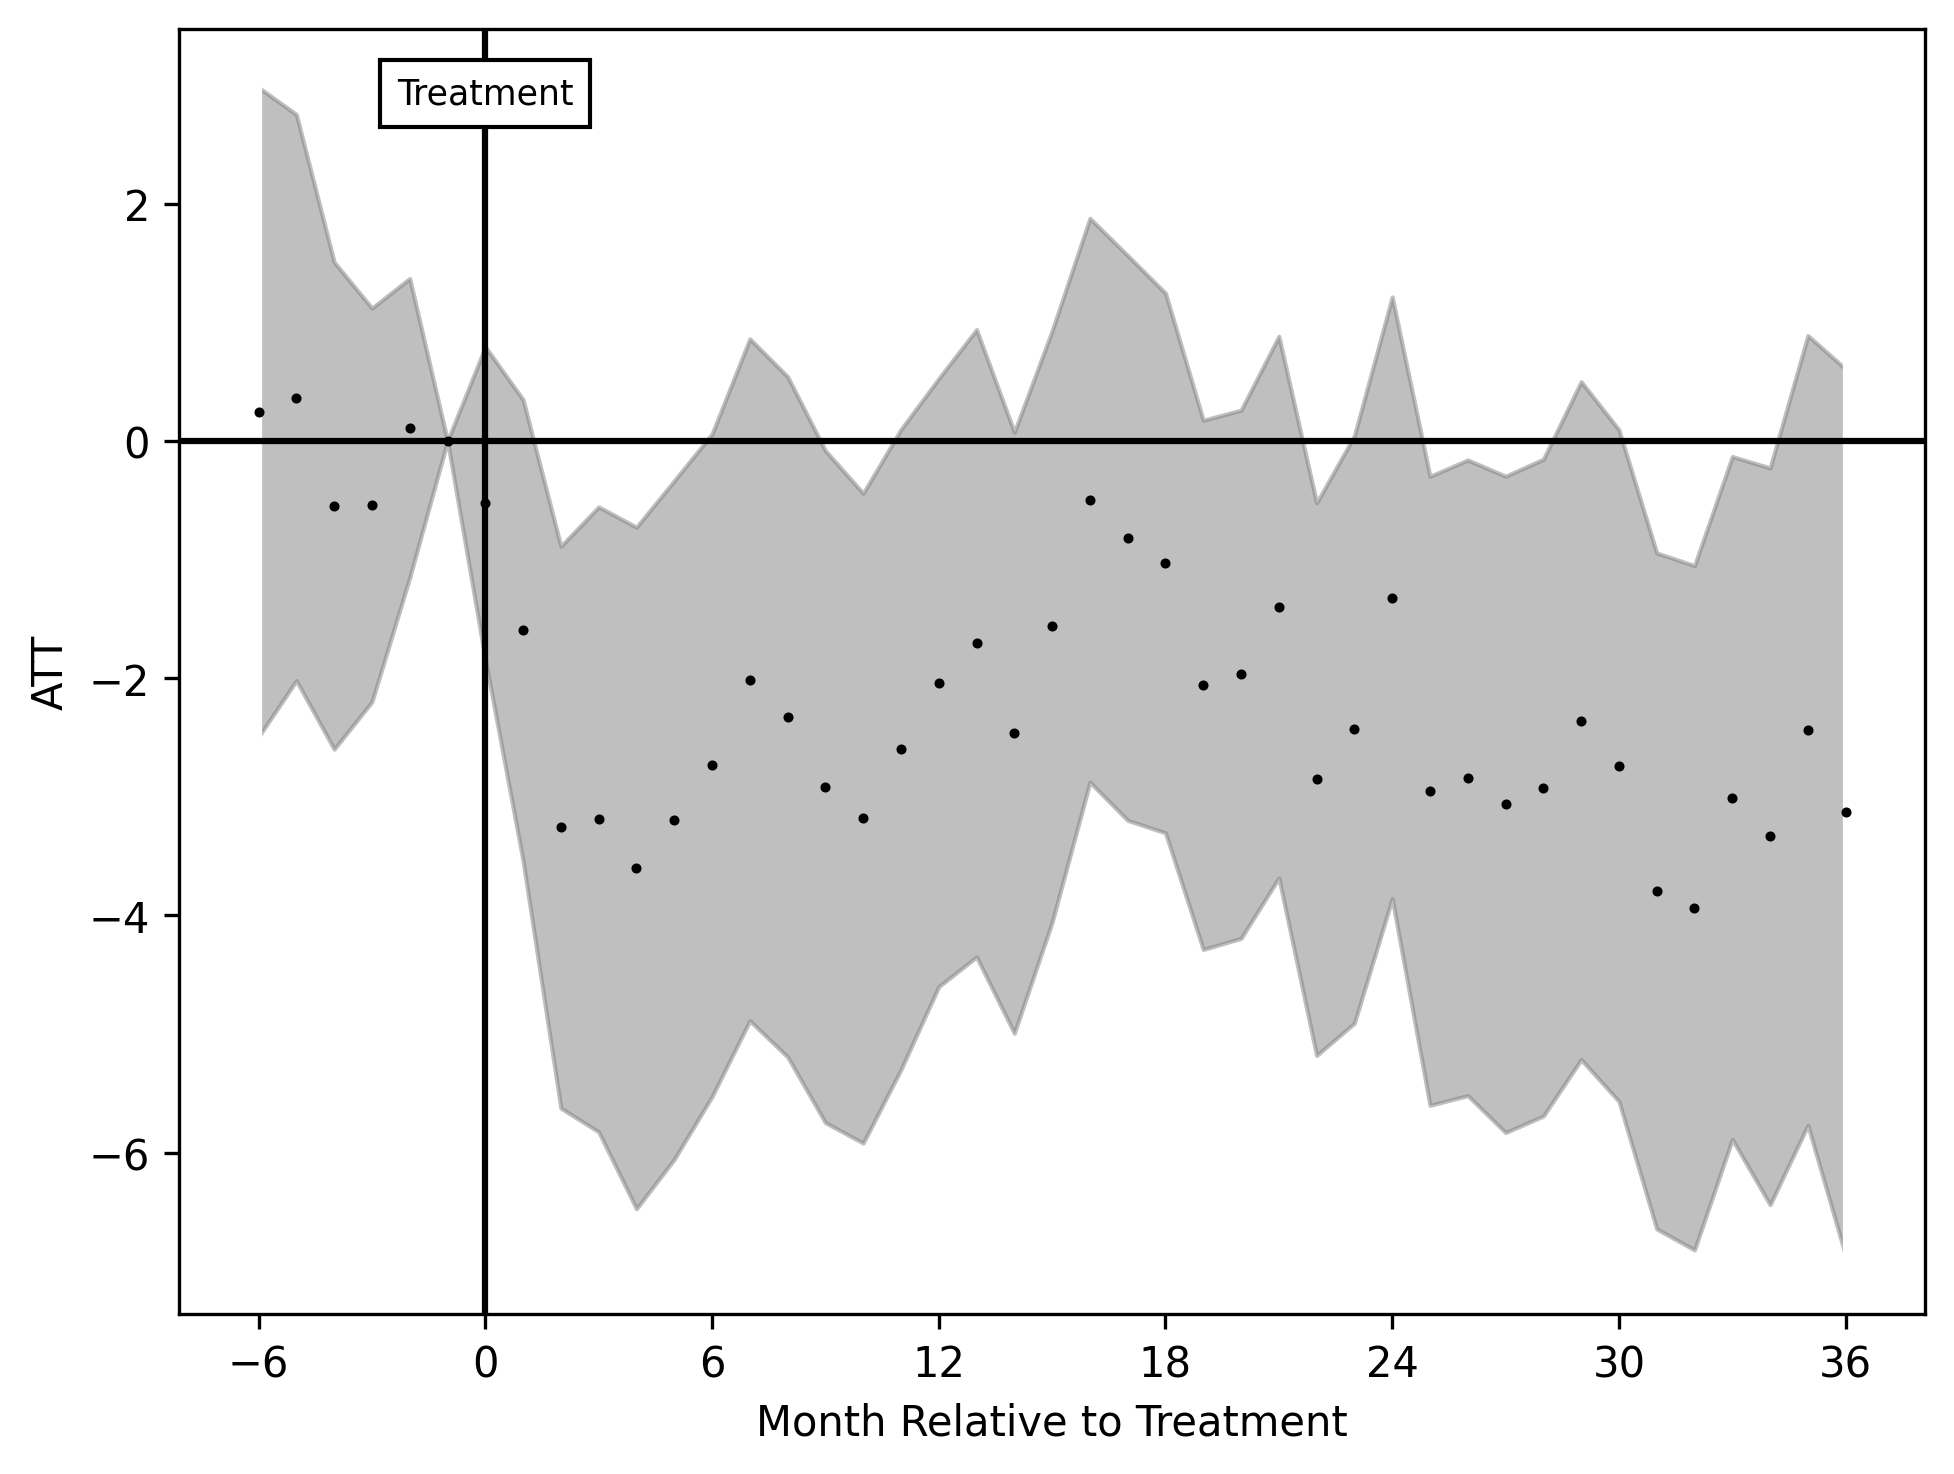

In [31]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

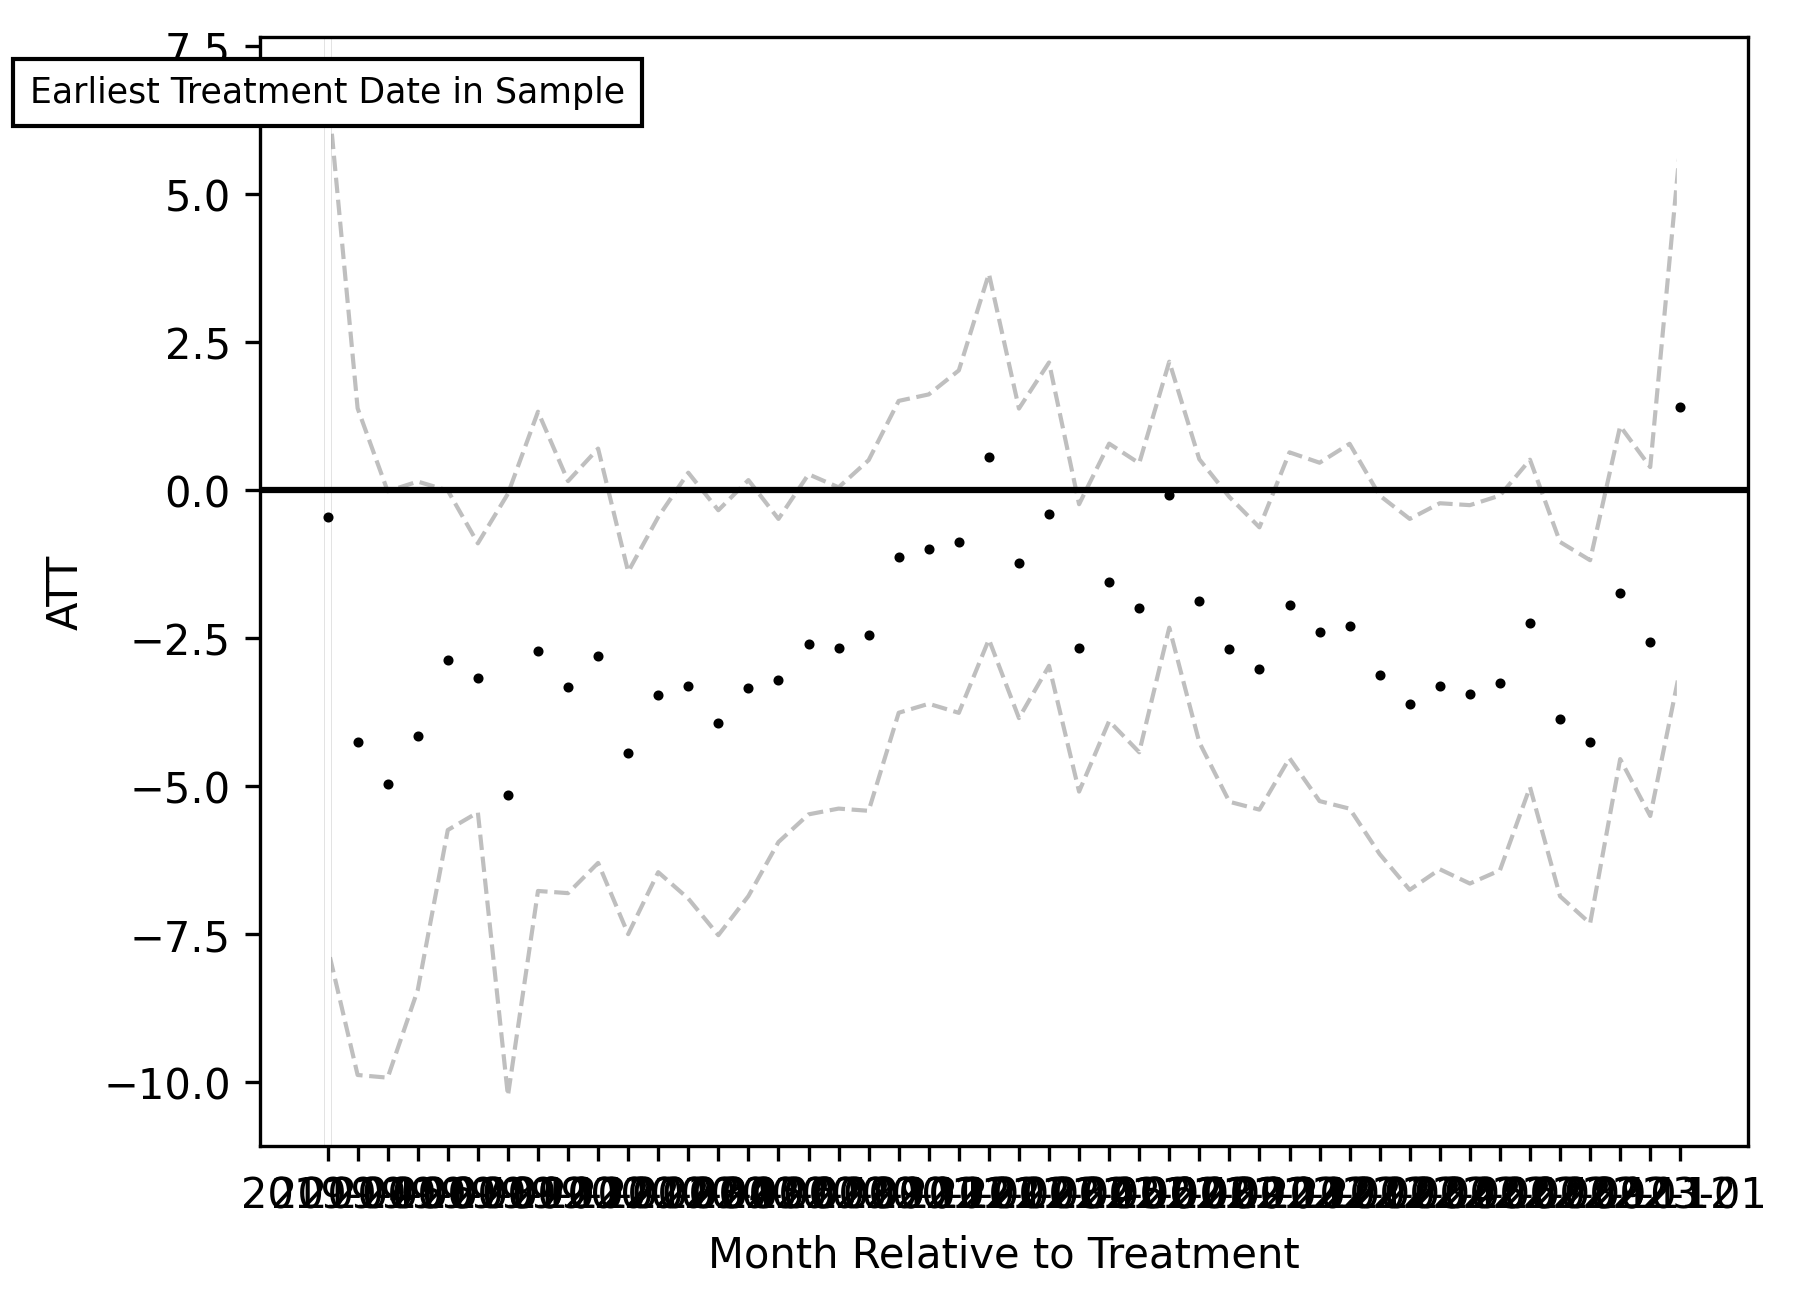

In [32]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [33]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:19<00:00, 56.32it/s] 


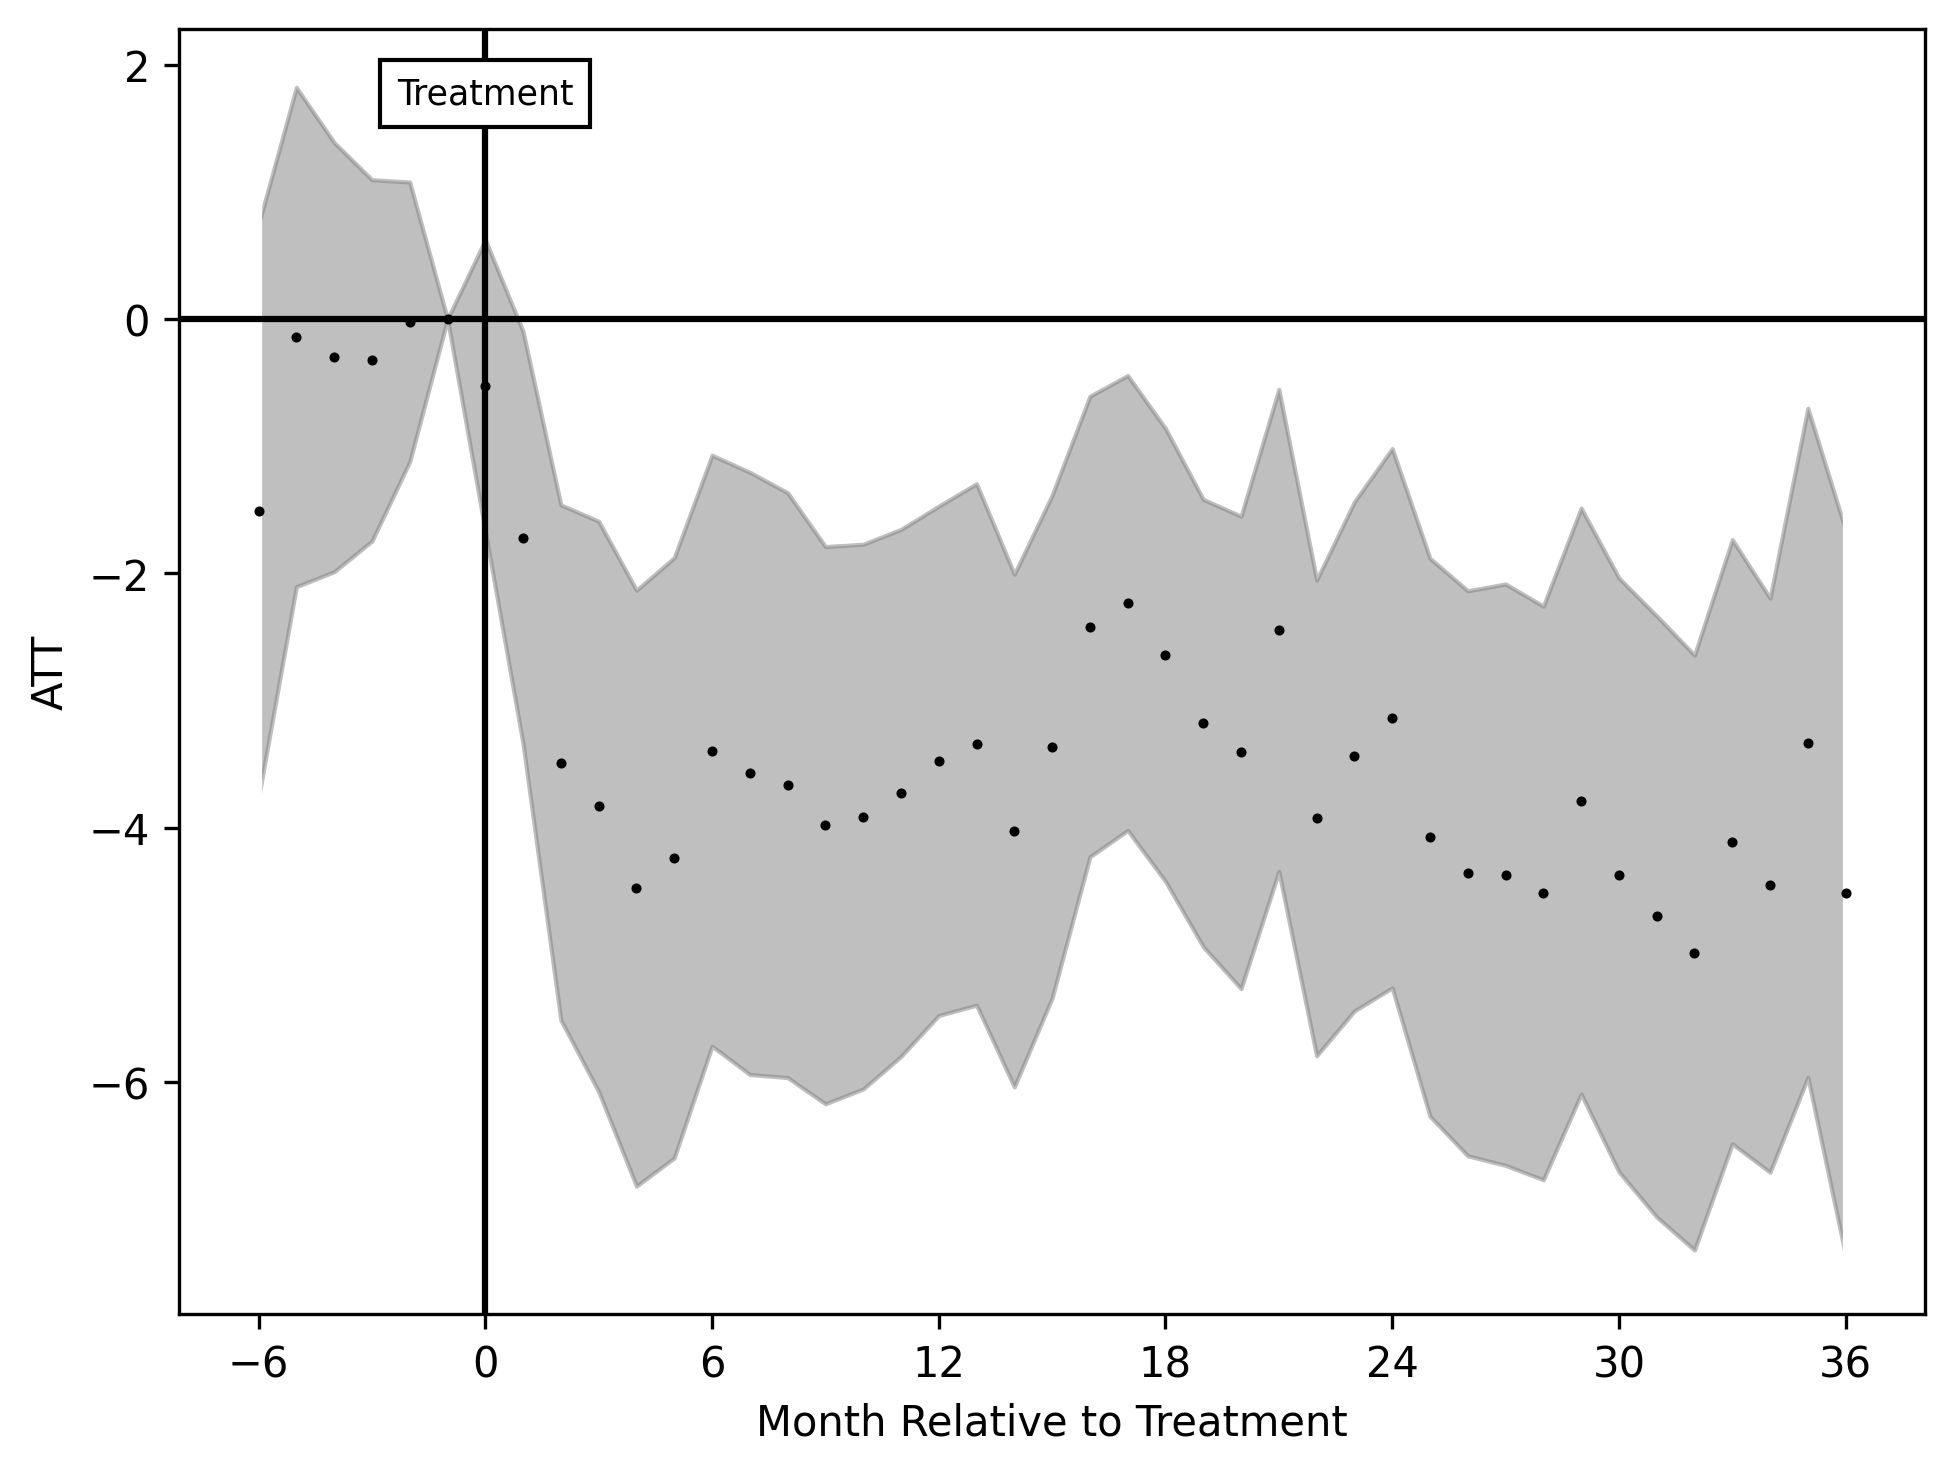

In [34]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

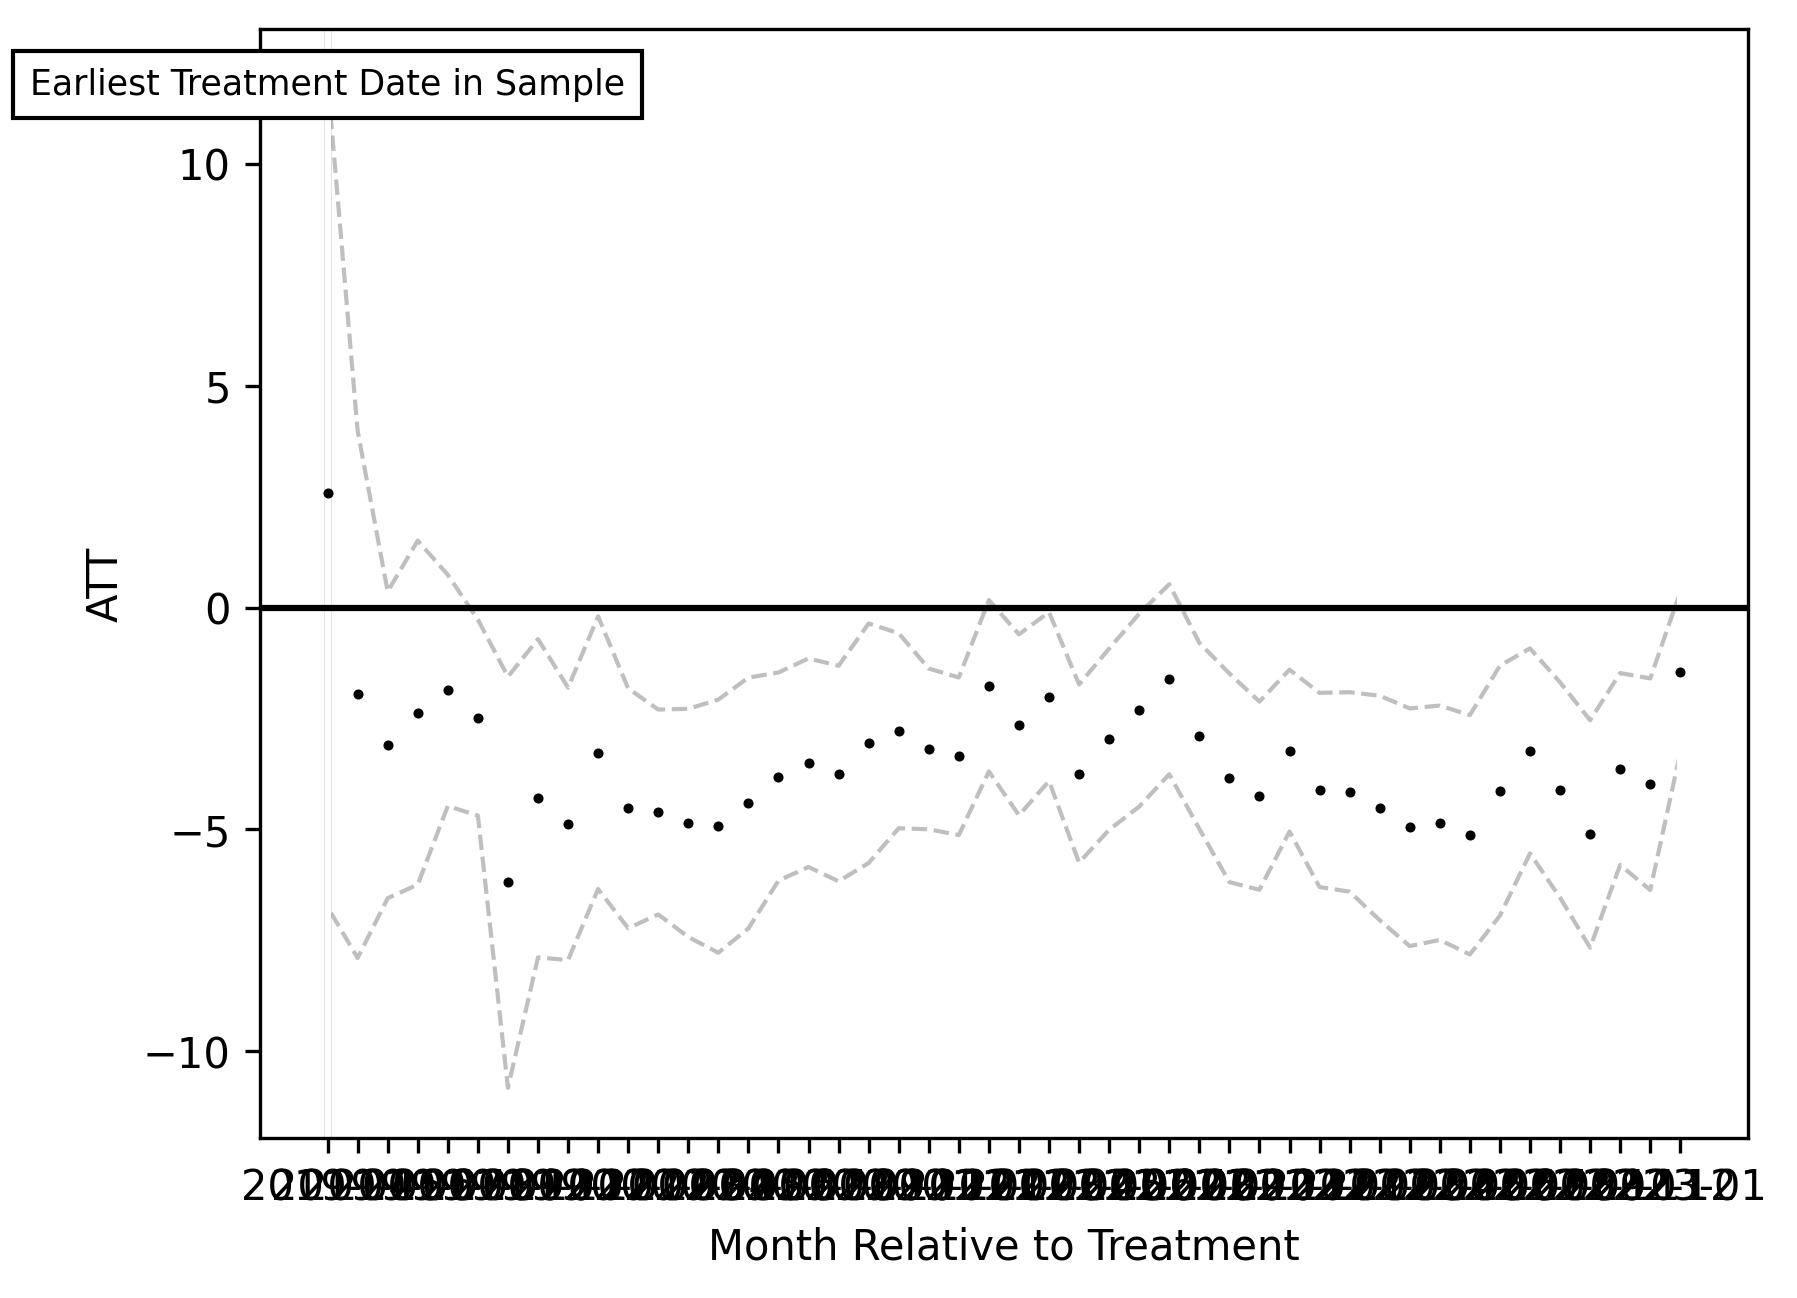

In [35]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")